In [1]:
# Uninstall old versions to avoid conflicts
!pip uninstall -y transformers peft accelerate

# Install latest libraries supporting Qwen2.5-VL
!pip install -q git+https://github.com/huggingface/transformers.git
!pip install git+https://github.com/huggingface/peft.git
!pip install git+https://github.com/huggingface/accelerate.git

!pip install -q nltk rouge_score
!pip install -q bitsandbytes
!pip install -q qwen-vl-utils
!pip install -q flash-attn --no-build-isolation
!pip install evaluate

# Install required packages
!pip install -q bitsandbytes qwen-vl-utils protobuf==3.20.3

Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
Found existing installation: peft 0.16.0
Uninstalling peft-0.16.0:
  Successfully uninstalled peft-0.16.0
Found existing installation: accelerate 1.9.0
Uninstalling accelerate-1.9.0:
  Successfully uninstalled accelerate-1.9.0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 534.5/534.5 kB 13.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 74.6 MB/s eta 0:00:00:00:01
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
datasets 4.4.1 requires pyarrow>=21.0.0, but you have pyarrow 19.0.1 which is incompatible.
sentence-transformers 4.1.0 requires transformers<5.0.0,>=4.41.0, but yo

In [2]:
import os
import torch
import json
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import Qwen3VLForConditionalGeneration, AutoProcessor, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model, TaskType
from qwen_vl_utils import process_vision_info
from tqdm import tqdm
import bitsandbytes as bnb
import matplotlib.pyplot as plt

import string
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
import numpy as np

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

# Setup & Configuration

def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)
device = "cuda"

BASE_DIR = '/kaggle/input/vqa-rad-visual-question-answering-radiology'
JSON_PATH = os.path.join(BASE_DIR, 'VQA_RAD Dataset Public.json')
IMAGE_DIR = os.path.join(BASE_DIR, 'VQA_RAD Image Folder')

# Hyperparameters
BATCH_SIZE = 2
GRAD_ACCUMULATION = 8
EPOCHS = 5
LEARNING_RATE = 1e-5
MODEL_ID = "Qwen/Qwen3-VL-4B-Instruct"

In [3]:
class VQAQwenDataset(Dataset):
    def __init__(self, df, img_dir, processor):
        self.df = df
        self.img_dir = img_dir
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image_name']
        question = row['question']
        answer = str(row['answer']).lower().strip()
        
        img_path = os.path.join(self.img_dir, img_name)
        
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))

        system_prompt = {
            "role": "system", 
            "content": "You are an expert radiologist. Answer the question concisely based on the image. If it is a Yes/No question, answer with just 'Yes' or 'No'."
        }

        messages = [
            system_prompt,
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": question}
                ]
            },
            {"role": "assistant", "content": answer}
        ]
        
        messages_prompt = [
            system_prompt,
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": question}
                ]
            }
        ]

        return {
            "messages": messages,
            "messages_prompt": messages_prompt
        }

def collate_fn(batch):
    messages = [x["messages"] for x in batch]
    messages_prompt = [x["messages_prompt"] for x in batch]
    
    texts = [processor.apply_chat_template(m, tokenize=False, add_generation_prompt=False) for m in messages]
    texts_prompt = [processor.apply_chat_template(m, tokenize=False, add_generation_prompt=True) for m in messages_prompt]
    
    image_inputs, video_inputs = process_vision_info(messages)
    
    inputs = processor(
        text=texts,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    
    inputs_prompt = processor(
        text=texts_prompt,
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    
    labels = inputs["input_ids"].clone()
    if processor.tokenizer.pad_token_id is not None:
        labels[labels == processor.tokenizer.pad_token_id] = -100
        
    for i in range(len(batch)):
        prompt_len = inputs_prompt["input_ids"][i].ne(processor.tokenizer.pad_token_id).sum().item()
        labels[i, :prompt_len] = -100
        
    inputs["labels"] = labels
    return inputs

In [4]:
# ==========================================
# Model Setup with QLoRA
# ==========================================
print(f"Loading {MODEL_ID} in 4-bit...")

# 4-bit quantization configuration
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16
)

# Load processor
processor = AutoProcessor.from_pretrained(MODEL_ID, min_pixels=256*28*28, max_pixels=384*28*28)

# Load model
model = Qwen3VLForConditionalGeneration.from_pretrained(
    MODEL_ID,
    device_map="auto",
    quantization_config=bnb_config,
    torch_dtype=torch.float16
)

# Configure LoRA
peft_config = LoraConfig(
    r=16,
    lora_alpha=16,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "gate_proj", "up_proj", "down_proj"],
    lora_dropout=0.1,
    bias="none",
    task_type="CAUSAL_LM",
    modules_to_save=[]
)

model = get_peft_model(model, peft_config)
model.print_trainable_parameters()

Loading Qwen/Qwen3-VL-4B-Instruct in 4-bit...


preprocessor_config.json:   0%|          | 0.00/390 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

video_preprocessor_config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Loading weights:   0%|          | 0/713 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

trainable params: 33,030,144 || all params: 4,470,845,952 || trainable%: 0.7388


In [5]:
# Prepare data
with open(JSON_PATH, 'r') as f:
    df = pd.DataFrame(json.load(f))

# Data cleaning
df['question'] = df['question'].astype(str)
df['answer'] = df['answer'].astype(str)

# Split by Image ID (ensure same image in one set)
from sklearn.model_selection import train_test_split

# Get unique image IDs
unique_img_ids = df['image_name'].unique()

# Split image IDs: 80% train, 20% temp (for val)
train_ids, temp_ids = train_test_split(unique_img_ids, test_size=0.2, random_state=42)

# Further split temp: 50% validation, 50% test
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Create dataframes based on image IDs
train_df = df[df['image_name'].isin(train_ids)].reset_index(drop=True)
val_df = df[df['image_name'].isin(val_ids)].reset_index(drop=True)

val_dataset = VQAQwenDataset(val_df, IMAGE_DIR, processor)

# Create DataLoaders
train_dataset = VQAQwenDataset(train_df, IMAGE_DIR, processor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(
    val_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=False, 
    collate_fn=collate_fn
)

print(f"Total Rows: {len(df)}")
print(f"Train Rows: {len(train_df)} (Images: {len(train_ids)})")
print(f"Val Rows: {len(val_df)} (Images: {len(val_ids)})")

Total Rows: 2248
Train Rows: 1831 (Images: 251)
Val Rows: 210 (Images: 31)


In [6]:
temp_dataset = VQAQwenDataset(train_df.iloc[:2], IMAGE_DIR, processor)
temp_item = temp_dataset[0]

batch = [temp_item]
processed_batch = collate_fn(batch)

print("Input IDs length:", len(processed_batch['input_ids'][0]))
print("Labels length:", len(processed_batch['labels'][0]))
print("Number of ignored tokens (-100):", (processed_batch['labels'][0] == -100).sum().item())

Input IDs length: 354
Labels length: 354
Number of ignored tokens (-100): 351


In [7]:
# Validation function
def validate(model, loader, device):
    model.eval()
    total_val_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(loader, desc="Validating", leave=False):
            # Move data to device
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            image_grid_thw = batch["image_grid_thw"].to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass (loss only)
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                pixel_values=pixel_values,
                image_grid_thw=image_grid_thw,
                labels=labels
            )
            
            # Accumulate loss
            total_val_loss += outputs.loss.item()
            
    avg_val_loss = total_val_loss / len(loader)
    model.train()
    return avg_val_loss

In [8]:
# ==========================================
# Training Loop
# ==========================================
optimizer = bnb.optim.PagedAdamW8bit(
    model.parameters(), 
    lr=LEARNING_RATE,
    weight_decay=0.05 
)

print("Start Fine-tuning Qwen3-VL...")
model.train()
best_val_loss = float('inf')

# Track metrics for visualization
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    optimizer.zero_grad()
    
    for step, batch in enumerate(progress_bar):
        # Move data to GPU
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        pixel_values = batch["pixel_values"].to(device)
        image_grid_thw = batch["image_grid_thw"].to(device)
        labels = batch["labels"].to(device)
        
        # Forward pass
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
            image_grid_thw=image_grid_thw,
            labels=labels
        )
        
        loss = outputs.loss / GRAD_ACCUMULATION
        loss.backward()
        
        if (step + 1) % GRAD_ACCUMULATION == 0:
            optimizer.step()
            optimizer.zero_grad()
        
        current_loss = loss.item() * GRAD_ACCUMULATION
        total_loss += current_loss
        progress_bar.set_postfix({"loss": current_loss})
    
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    val_loss = validate(model, val_loader, device)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch+1} | Train Loss: {avg_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # Save best model
    if val_loss < best_val_loss:
        print(f"Val Loss improved from {best_val_loss:.4f} to {val_loss:.4f}. Saving Best Model...")
        best_val_loss = val_loss
        
        # Save model
        model.save_pretrained("qwen_lora_best")
        processor.save_pretrained("qwen_lora_best")
    else:
        print("Val Loss did not improve.")
        
    # Save LoRA weights
    model.save_pretrained(f"qwen_lora_epoch_{epoch+1}")

print("Fine-tuning Finished!")

Start Fine-tuning Qwen3-VL...



Epoch 1: 100%|██████████| 916/916 [23:24<00:00,  1.53s/it, loss=0.0432]


Epoch 1 | Train Loss: 1.1909 | Val Loss: 0.7464
Val Loss improved from inf to 0.7464. Saving Best Model...


Epoch 2: 100%|██████████| 916/916 [23:28<00:00,  1.54s/it, loss=1.96]   


Epoch 2 | Train Loss: 0.6824 | Val Loss: 0.6709
Val Loss improved from 0.7464 to 0.6709. Saving Best Model...


Epoch 3: 100%|██████████| 916/916 [23:26<00:00,  1.54s/it, loss=1.59]   


Epoch 3 | Train Loss: 0.6049 | Val Loss: 0.6486
Val Loss improved from 0.6709 to 0.6486. Saving Best Model...


Epoch 4: 100%|██████████| 916/916 [23:25<00:00,  1.53s/it, loss=2.03]    


Epoch 4 | Train Loss: 0.5554 | Val Loss: 0.6435
Val Loss improved from 0.6486 to 0.6435. Saving Best Model...


Epoch 5: 100%|██████████| 916/916 [23:27<00:00,  1.54s/it, loss=0.0124] 


Epoch 5 | Train Loss: 0.4886 | Val Loss: 0.6599
Val Loss did not improve.
Fine-tuning Finished!


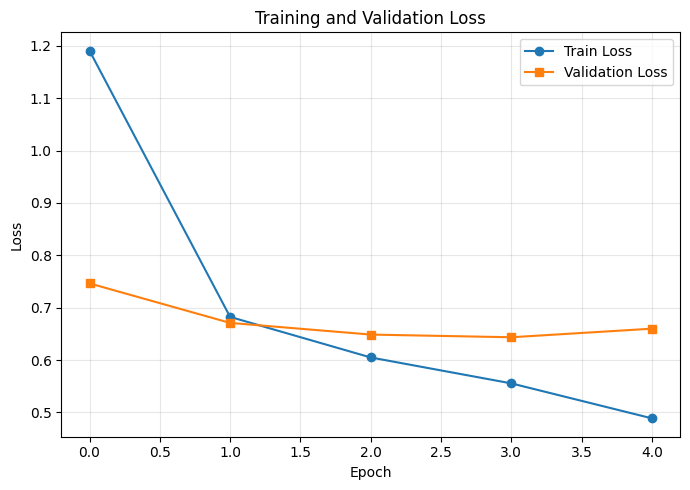

Training loss curve saved as 'training_loss_curve_qwen3vl.png'


In [9]:
# Visualize training curves
fig, ax = plt.subplots(figsize=(7, 5))

# Loss curve
ax.plot(train_losses, label='Train Loss', marker='o')
ax.plot(val_losses, label='Validation Loss', marker='s')
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training and Validation Loss')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_loss_curve_qwen3vl.png', dpi=100, bbox_inches='tight')
plt.show()

print("Training loss curve saved as 'training_loss_curve_qwen3vl.png'")

In [10]:
def evaluate_model_qwen(model, df, img_dir):
    model.eval()
    results = []
    print("Running Inference...")
    
    system_prompt = {
        "role": "system", 
        "content": "You are an expert radiologist. Answer the question concisely based on the image. If it is a Yes/No question, answer with just 'Yes' or 'No'."
    }
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_name = row['image_name']
        question = row['question']
        gt_answer = str(row['answer']).lower().strip()
        ans_type = row['answer_type']
        
        img_path = os.path.join(img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224), (0, 0, 0))
            
        messages = [
            system_prompt,
            {
                "role": "user",
                "content": [
                    {"type": "image", "image": image},
                    {"type": "text", "text": question}
                ]
            }
        ]
        
        text = processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        image_inputs, video_inputs = process_vision_info(messages)
        
        inputs = processor(
            text=[text],
            images=image_inputs,
            videos=video_inputs,
            padding=True,
            return_tensors="pt",
        )
        
        inputs = inputs.to(device)
        
        with torch.no_grad():
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=50,  
                do_sample=False,  
                num_beams=1,
                repetition_penalty=1.1
            )
            
        generated_ids_trimmed = [
            out_ids[len(in_ids):] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
        ]
        
        pred_answer = processor.batch_decode(
            generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
        )[0].lower().strip()
        
        results.append({
            "question": question,
            "image_name": img_name,
            "ground_truth": gt_answer,
            "prediction": pred_answer,
            "answer_type": ans_type
        })
        
    return pd.DataFrame(results)

# Run evaluation
val_results_df = evaluate_model_qwen(model, val_df, IMAGE_DIR)

Running Inference...


100%|██████████| 210/210 [03:07<00:00,  1.12it/s]


In [11]:
import pandas as pd
import string
import nltk
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import precision_recall_fscore_support
import numpy as np

try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')

def clean_text(text):
    text = str(text).lower().strip()
    # 去除标点
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

print("Cleaning predictions for metric calculation...")
val_results_df['prediction_clean'] = val_results_df['prediction'].apply(clean_text)
val_results_df['ground_truth_clean'] = val_results_df['ground_truth'].apply(clean_text)

# Closed-ended Accuracy
closed_df = val_results_df[val_results_df['answer_type'] == 'CLOSED'].copy()
correct_count = 0
total_closed = len(closed_df)

for _, row in closed_df.iterrows():
    pred = row['prediction_clean']
    gt = row['ground_truth_clean']
    if gt in pred or pred in gt: # 宽松匹配
        correct_count += 1
        
closed_acc = correct_count / total_closed if total_closed > 0 else 0.0

# 计算 Precision, Recall, F1 for Yes/No questions
valid_answers = ['yes', 'no']

closed_eval_df = closed_df[
    closed_df['ground_truth_clean'].isin(valid_answers) &
    closed_df['prediction_clean'].isin(valid_answers)
]

if len(closed_eval_df) > 0:
    y_true = closed_eval_df['ground_truth_clean'].values
    y_pred = closed_eval_df['prediction_clean'].values

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=['yes', 'no'],
        average='binary',
        pos_label='yes',
        zero_division=0
    )
else:
    precision = recall = f1 = 0.

# Open-ended Metrics (Accuracy, BLEU, ROUGE)
open_df = val_results_df[val_results_df['answer_type'] == 'OPEN'].copy()

bleu_scores = []
rouge_l_scores = []
open_correct_count = 0
total_open = len(open_df)

# 初始化 ROUGE 计算器
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
# 平滑函数
cc = SmoothingFunction()

for _, row in open_df.iterrows():
    pred = row['prediction_clean']
    gt = row['ground_truth_clean']
    
    # --- 1. Accuracy Calculation ---
    if gt == pred or (len(gt) > 2 and gt in pred): 
        open_correct_count += 1

    # --- 2. BLEU Calculation ---
    ref_tokens = [gt.split()] 
    pred_tokens = pred.split()
    
    if len(pred_tokens) == 0:
        b_score = 0.0
    else:
        b_score = sentence_bleu(ref_tokens, pred_tokens, weights=(0.5, 0.5), smoothing_function=cc.method1)
    bleu_scores.append(b_score)
    
    # --- 3. ROUGE-L Calculation ---
    scores = scorer.score(gt, pred)
    rouge_l_scores.append(scores['rougeL'].fmeasure)

avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
avg_rouge = np.mean(rouge_l_scores) if rouge_l_scores else 0.0
open_acc = open_correct_count / total_open if total_open > 0 else 0.0

print("\n" + "="*60)
print("FINAL EVALUATION REPORT (QWEN3-VL)")
print("="*60)
print(f"Total Samples          : {len(val_results_df)}")
print("-" * 40)
print(f"Closed-ended Accuracy  : {closed_acc * 100:.2f}%")
print(f"Precision              : {precision * 100:.2f}%")
print(f"Recall                 : {recall * 100:.2f}%")
print(f"F1-score               : {f1 * 100:.2f}%")
print("-" * 40)
print(f"Open-ended Accuracy    : {open_acc * 100:.2f}%")
print(f"Open-ended BLEU Score  : {avg_bleu * 100:.2f}")
print(f"Open-ended ROUGE-L     : {avg_rouge * 100:.2f}")
print("="*60)

Cleaning predictions for metric calculation...

FINAL EVALUATION REPORT (QWEN3-VL)
Total Samples          : 210
----------------------------------------
Closed-ended Accuracy  : 76.72%
Precision              : 80.00%
Recall                 : 75.86%
F1-score               : 77.88%
----------------------------------------
Open-ended Accuracy    : 32.98%
Open-ended BLEU Score  : 18.95
Open-ended ROUGE-L     : 43.79



 Correct Prediction Examples


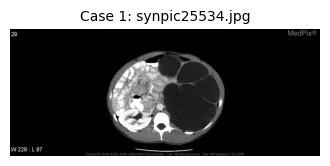

▶ Case 1 ( Correct)
  • Question     : Was this patient given IV contrast?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


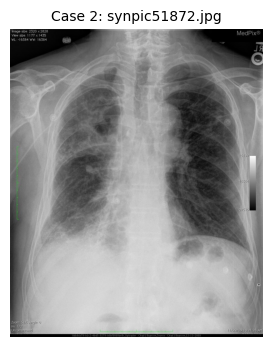

▶ Case 2 ( Correct)
  • Question     : what is the location of the cavitary lesion
  • Ground Truth : right upper lobe
  • Prediction   : right upper lobe
  • Answer Type  : OPEN
------------------------------------------------------------


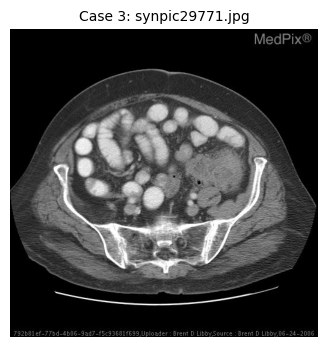

▶ Case 3 ( Correct)
  • Question     : Is the bowel perforated?
  • Ground Truth : no
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


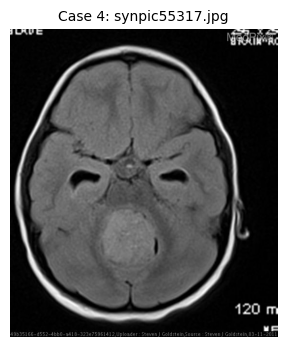

▶ Case 4 ( Correct)
  • Question     : Does this patient have a skull fracture?
  • Ground Truth : no
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


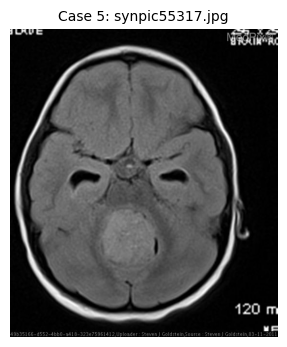

▶ Case 5 ( Correct)
  • Question     : In what ventricle is the enhancing intraventricular mass seen?
  • Ground Truth : 4th ventricle
  • Prediction   : 4th ventricle
  • Answer Type  : OPEN
------------------------------------------------------------


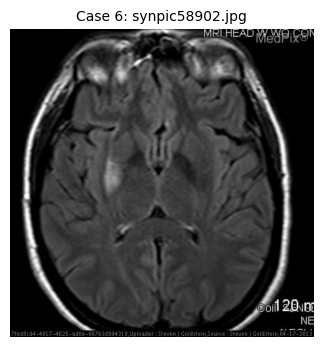

▶ Case 6 ( Correct)
  • Question     : Is this a T1 weighted, T2 weighted, or FLAIR image?
  • Ground Truth : flair
  • Prediction   : flair
  • Answer Type  : CLOSED
------------------------------------------------------------


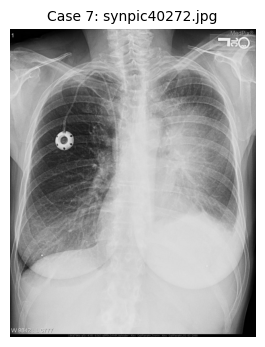

▶ Case 7 ( Correct)
  • Question     : was this chest x ray taken in PA format?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


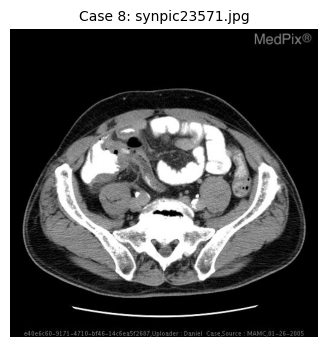

▶ Case 8 ( Correct)
  • Question     : Is the appendix enlarged?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


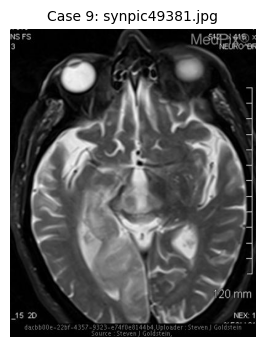

▶ Case 9 ( Correct)
  • Question     : Is the brain atrophied or shrunk?
  • Ground Truth : no
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


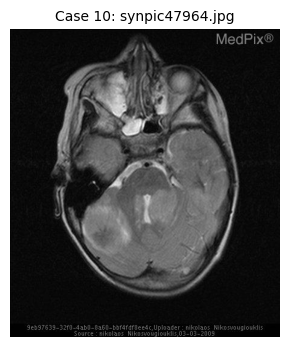

▶ Case 10 ( Correct)
  • Question     : What type of modality was this image taken?
  • Ground Truth : mri - t2 weighted
  • Prediction   : mri - t2 weighted
  • Answer Type  : OPEN
------------------------------------------------------------

 Incorrect Prediction Examples


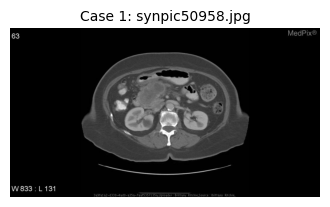

▶ Case 1 ( Incorrect)
  • Question     : Can a mass in the pancreatic head cause a liver injury?
  • Ground Truth : yes
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


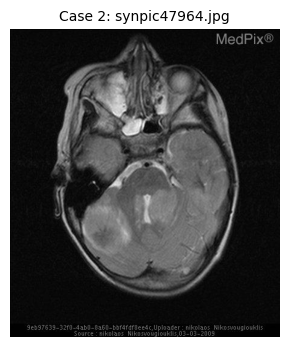

▶ Case 2 ( Incorrect)
  • Question     : What is the MR weighting in this image?
  • Ground Truth : mri - t2 weighted
  • Prediction   : t2 weighted
  • Answer Type  : OPEN
------------------------------------------------------------


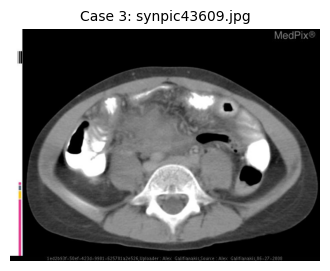

▶ Case 3 ( Incorrect)
  • Question     : This image is consistent with what condition?
  • Ground Truth : appendicitis
  • Prediction   : diverticulitis
  • Answer Type  : OPEN
------------------------------------------------------------


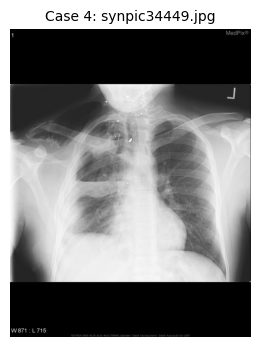

▶ Case 4 ( Incorrect)
  • Question     : Where in the image are the calcifications located?
  • Ground Truth : high on the image
  • Prediction   : right upper lobe
  • Answer Type  : OPEN
------------------------------------------------------------


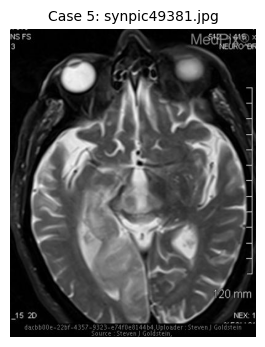

▶ Case 5 ( Incorrect)
  • Question     : What are these hyperintensities to the right?
  • Ground Truth : infarcted areas
  • Prediction   : right occipital lobe and left temporal lobe
  • Answer Type  : OPEN
------------------------------------------------------------


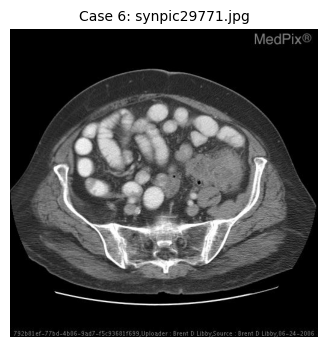

▶ Case 6 ( Incorrect)
  • Question     : Is the lesion in the image enhancing?
  • Ground Truth : no
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


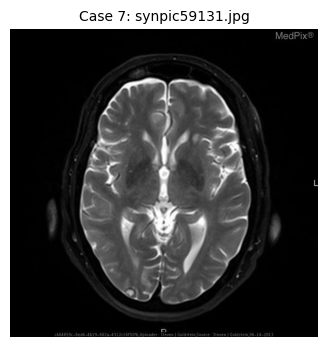

▶ Case 7 ( Incorrect)
  • Question     : What is seen in the occipital lobe?
  • Ground Truth : ring enhancing lesion
  • Prediction   : hyperintensity
  • Answer Type  : OPEN
------------------------------------------------------------


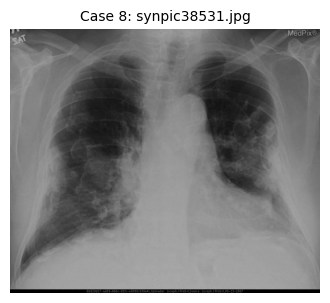

▶ Case 8 ( Incorrect)
  • Question     : Are pleural opacities located on the left, right, or both sides of the lung?
  • Ground Truth : both
  • Prediction   : right side
  • Answer Type  : CLOSED
------------------------------------------------------------


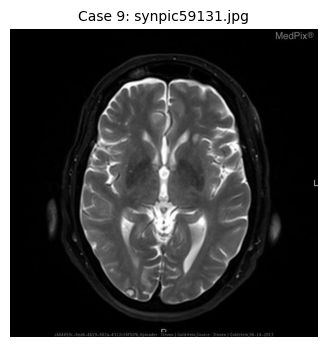

▶ Case 9 ( Incorrect)
  • Question     : What is abnormal about the occipital lobe?
  • Ground Truth : ring enhancing lesion
  • Prediction   : hyperintensity
  • Answer Type  : OPEN
------------------------------------------------------------


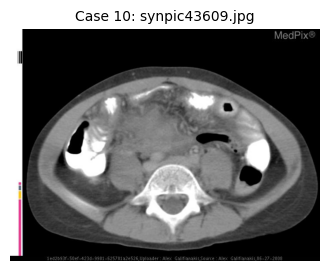

▶ Case 10 ( Incorrect)
  • Question     : What organ is edematous in this image?
  • Ground Truth : appendix
  • Prediction   : intestine
  • Answer Type  : OPEN
------------------------------------------------------------


In [12]:
import os
import matplotlib.pyplot as plt
from PIL import Image

def visualize_vqa_point_form(df, img_dir, title, num_samples=3):
    if len(df) == 0:
        print(f"No samples found for: {title}")
        return

    samples = df.sample(min(num_samples, len(df)))

    print(f"\n{title}")
    print("=" * len(title))

    for i, (_, row) in enumerate(samples.iterrows(), 1):
        img_path = os.path.join(img_dir, row['image_name'])

        # --- 顯示圖片 ---
        plt.figure(figsize=(4, 4))
        try:
            img = Image.open(img_path).convert("RGB")
            plt.imshow(img)
            plt.title(f"Case {i}: {row['image_name']}", fontsize=10)
        except:
            plt.text(0.5, 0.5, "Image Not Found", ha='center', va='center')
        plt.axis("off")
        plt.show()

        # --- Point form 文字 ---
        is_correct = row['prediction_clean'] == row['ground_truth_clean']
        status = " Correct" if is_correct else " Incorrect"

        print(f"▶ Case {i} ({status})")
        print(f"  • Question     : {row['question']}")
        print(f"  • Ground Truth : {row['ground_truth']}")
        print(f"  • Prediction   : {row['prediction']}")
        print(f"  • Answer Type  : {row['answer_type']}")
        print("-" * 60)


# 正确样本
correct_examples = val_results_df[
    val_results_df['prediction_clean'] == val_results_df['ground_truth_clean']
]
visualize_vqa_point_form(
    correct_examples,
    IMAGE_DIR,
    " Correct Prediction Examples",
    num_samples=10
)

# 错误样本
incorrect_examples = val_results_df[
    val_results_df['prediction_clean'] != val_results_df['ground_truth_clean']
]
visualize_vqa_point_form(
    incorrect_examples,
    IMAGE_DIR,
    " Incorrect Prediction Examples",
    num_samples=10
)


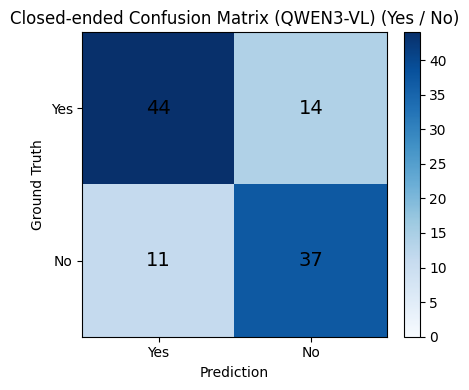

In [13]:
# ==========================================
# Confusion Matrix for Closed-ended Questions
# ==========================================
import matplotlib.pyplot as plt
import numpy as np

closed_df_cm = val_results_df[val_results_df['answer_type'] == 'CLOSED'].copy()

valid_answers = ['yes', 'no']
closed_df_cm = closed_df_cm[
    closed_df_cm['ground_truth_clean'].isin(valid_answers) &
    closed_df_cm['prediction_clean'].isin(valid_answers)
]

cm = np.zeros((2, 2), dtype=int)

label_to_idx = {'yes': 0, 'no': 1}

for _, row in closed_df_cm.iterrows():
    gt_idx = label_to_idx[row['ground_truth_clean']]
    pred_idx = label_to_idx[row['prediction_clean']]
    cm[gt_idx, pred_idx] += 1

fig, ax = plt.subplots(figsize=(5, 4))

im = ax.imshow(cm, cmap='Blues', vmin=0, vmax=np.max(cm))

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])

ax.set_xlabel("Prediction")
ax.set_ylabel("Ground Truth")
ax.set_title("Closed-ended Confusion Matrix (QWEN3-VL) (Yes / No)")

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=14, color='black')

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()
